In [2]:
import os
import cv2
import time
import numpy as np
from PIL import Image
import torch
import albumentations as A
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

import torch.nn as nn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
import torch.nn.functional as F
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
import torchvision.ops as ops


In [19]:
!tar -xf traindo1.tar -C ./do1/
!tar -xf train.tar


In [20]:
MAX_BOXES = 10
BATCH_SIZE = 8

DATASET


In [21]:
class BoneFractureDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = cv2.imread(image_path)

        # Convert image to RGB (OpenCV loads images as BGR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image=image)
            image = image['image']
        else:
            # Default transformation to tensor and normalization
            image = transforms.ToTensor()(image)

        label_path = os.path.join(self.label_dir, os.path.basename(image_path).replace('.jpg', '.txt'))
        with open(label_path, 'r') as f:
            labels = f.readlines()

        boxes = []
        for label in labels:
            parts = label.strip().split()
            class_id = int(parts[0])
            bbox = list(map(float, parts[1:]))
            if len(boxes) < MAX_BOXES:
                boxes.append([bbox[0]-bbox[2],bbox[1]-bbox[3],bbox[0]+bbox[2],bbox[1]+bbox[3]])

        target = {"boxes": torch.tensor(boxes, dtype=torch.float32), "labels": torch.tensor([1 for _ in range(len(boxes))], dtype=torch.int64)}

        return image, target

# Augmentation transforms
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussianBlur(p=0.5),
    A.Normalize(),
    ToTensorV2()
])
# Create datasets for train, validation, and test sets
train_dataset = BoneFractureDataset(image_dir='do1/train/images', label_dir='do1/train/labels', transform=transform)
valid_dataset = BoneFractureDataset(image_dir='do1/valid/images', label_dir='do1/valid/labels')
test_dataset = BoneFractureDataset(image_dir='do1/test/images', label_dir='do1/test/labels')

def collate_fn(batch):
    return tuple(zip(*batch))

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
val_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)


In [22]:
print(f"TRAIN IMAGES: {len(train_dataset)} VALID. IMAGES: {len(valid_dataset)} TEST IMAGES: {len(test_dataset)}")

TRAIN IMAGES: 713 VALID. IMAGES: 204 TEST IMAGES: 102


MODEL

In [23]:
import torch
import torch.nn as nn
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch.nn.functional as F

class CustomBoxHead(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(CustomBoxHead, self).__init__()
        self.fc1 = nn.Linear(in_channels, 1024)
        self.dropout = nn.Dropout(p=0.5)  # Dropout layer with 50% dropout rate
        self.fc2 = nn.Linear(1024, num_classes)
        self.fc_box = nn.Linear(1024, num_classes * 4)  # For box regression

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout
        class_logits = self.fc2(x)
        box_regression = self.fc_box(x)  # Box regression output
        return class_logits, box_regression  # Return both outputs

class BoneFractureFasterRCNN(FasterRCNN):
    def __init__(self, backbone, num_classes):
        super(BoneFractureFasterRCNN, self).__init__(backbone, num_classes)
        in_features = self.roi_heads.box_predictor.cls_score.in_features
        self.roi_heads.box_predictor = CustomBoxHead(in_features, num_classes)

    def forward(self, images, targets=None):
        if self.training and targets is not None:
            return super().forward(images, targets)
        else:
            return super().forward(images)


In [24]:
# Create the ResNet-18 backbone with FPN
backbone = resnet_fpn_backbone('resnet18', pretrained=True)
backbone.out_channels = 256

# Create the Faster R-CNN model with the backbone and the custom head
model = BoneFractureFasterRCNN(
    backbone,
    num_classes=2,  # 1 class (object) + background
)

# Switch the model to evaluation mode
model.eval()



BoneFractureFasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3

In [25]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


In [26]:
print(f"Total model parameters: {sum([param.nelement() for param in model.parameters()])}")

Total model parameters: 29323481


In [27]:
def inference(loader, model):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)
    model.eval()

    all_predictions = []

    with torch.no_grad():
        for images, targets in loader:
            images = list(image.to(device) for image in images)

            # Perform inference
            predictions = model(images)

            all_predictions.extend(predictions)

    return all_predictions

def evaluate(loader, model):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)
    model.train()  # Use train mode to get loss values

    total_loss = 0.0
    with torch.no_grad():
        for images, targets in loader:
            #print(len(targets))
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Forward pass
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            loss_dict = None
            images = None
            targets = None

            total_loss += losses.item()

    avg_loss = total_loss / len(loader)
    model.eval()  # Switch back to eval mode
    return avg_loss



In [28]:
train_dataset_do1 = BoneFractureDataset(image_dir='do1/train/images', label_dir='do1/train/labels', transform=transform)
train_loader_do1 = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

val_dataset_do1 = BoneFractureDataset(image_dir='do1/valid/images', label_dir='do1/valid/labels', transform=transform)
val_loader_do1 = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

train_dataset = BoneFractureDataset(image_dir='train/images', label_dir='train/labels', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

val_dataset = BoneFractureDataset(image_dir='valid/images', label_dir='valid/labels', transform=transform)
val_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

In [29]:
print("bone-fractue-yzkpo train dataset: ", len(train_dataset))
print("bone-fractue-yzkpo validation dataset: ", len(val_dataset))
print("do1 train dataset: ", len(train_dataset_do1))
print("do1 validation dataset: ", len(val_dataset_do1))

bone-fractue-yzkpo train dataset:  366
bone-fractue-yzkpo validation dataset:  35
do1 train dataset:  713
do1 validation dataset:  204


TRAINING

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
lr = 1e-6
epoch_number = 10  # Adjust as necessary
noise_eps = 1.0  # Privacy parameter, adjust as necessary
delta = 1e-5  # Probability of privacy being violated


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
lr = 1e-7
epoch_number = 10
eps = 0.1
delta = 1e-5 # Probability of privacy being violated

def add_gaussian_noise(update, epsilon, delta, device):
    # Calculate the standard deviation of the Gaussian noise
    sigma = np.sqrt(2 * np.log(1.25 / delta)) / epsilon

    # Generate Gaussian noise
    noise = np.random.normal(0, sigma, update.size())

    # Add the noise to the update and ensure the noise is on the same device
    noisy_update = update + torch.tensor(noise, dtype=update.dtype).to(device)

    return noisy_update

def train(loader, model, device):
    model.train()
    grads = [torch.zeros_like(param, device=device) for param in model.parameters()]
    for images, targets in loader:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        # Backward pass
        losses.backward()

        # Accumulate gradients
        for i, param in enumerate(model.parameters()):
            if param.grad is not None:
                grads[i] += param.grad.clone()

    return grads

for epoch in range(epoch_number):
    # Train on loader_do1 and accumulate gradients
    grads_do1 = train(train_loader_do1, model, device)

    # Train on train_loader and accumulate gradients
    grads = train(train_loader, model, device)

    # Apply Gaussian noise
    noisy_grads_do1 = [add_gaussian_noise(grad, eps, delta, device) for grad in grads_do1]
    noisy_grads = [add_gaussian_noise(grad, eps, delta, device) for grad in grads]

    # Average the gradients and apply them
    with torch.no_grad():
        for i, param in enumerate(model.parameters()):
            avg_grad = (noisy_grads_do1[i] + noisy_grads[i]) / 2
            param -= lr * avg_grad

    print(f'Epoch {epoch + 1} completed')

    model.eval()
    val_loss_do1 = evaluate(val_loader_do1, model)
    val_loss = evaluate(val_loader, model)

    print(f'Epoch {epoch+1}, Val Loss do1: {val_loss_do1} Val Loss: {val_loss}')
    torch.save({
      'epoch': epoch,
      'model_state_dict': model.state_dict(),
      'loss': val_loss,
  }, f'BoneFractureFasterRCNN-gauss-noise-1e-5-epoch{epoch}.pth')


In [ ]:
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'loss': val_loss,
}, 'BoneFractureFasterRCNN-gauss-noise-1e-5.pth')


In [32]:
import torchvision.ops as ops

def apply_nms(predictions, iou_threshold=0.5):
    keep = ops.nms(predictions['boxes'], predictions['scores'], iou_threshold)
    final_boxes = predictions['boxes'][keep]
    final_scores = predictions['scores'][keep]
    final_labels = predictions['labels'][keep]

    return {
        'boxes': final_boxes,
        'scores': final_scores,
        'labels': final_labels
    }



In [33]:
checkpoint = torch.load('BoneFractureFasterRCNN-gauss-noise-1e-5.pth',map_location=torch.device('cpu'))
if checkpoint.get('model_state_dict', None) is not None:

    model.load_state_dict(checkpoint['model_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
else:
    model.load_state_dict(checkpoint)
model.train()

<ipython-input-33-07f9150f2b36>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('BoneFractureFasterRCNN-gauss-noise-1e-5.pth',map_location=torch.dev

BoneFractureFasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3

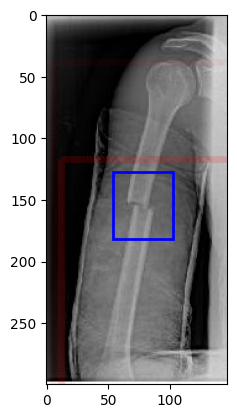

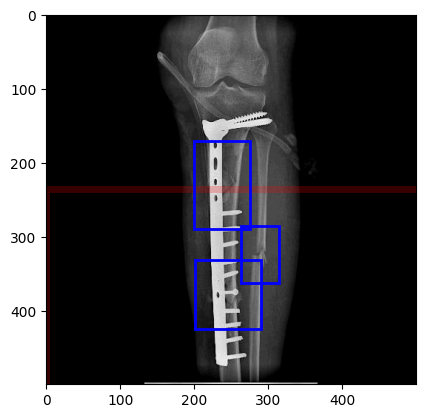

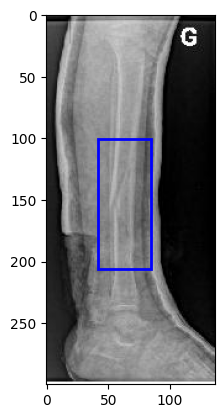

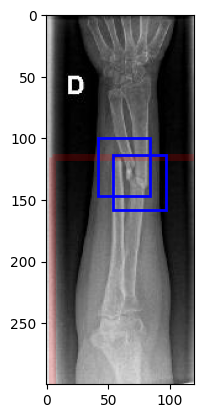

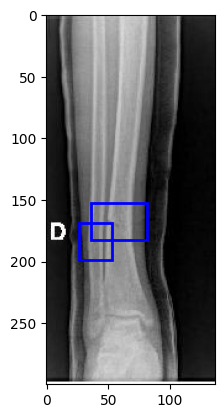

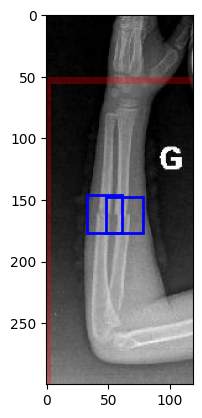

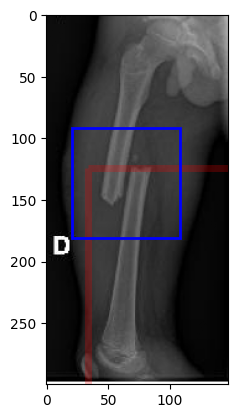

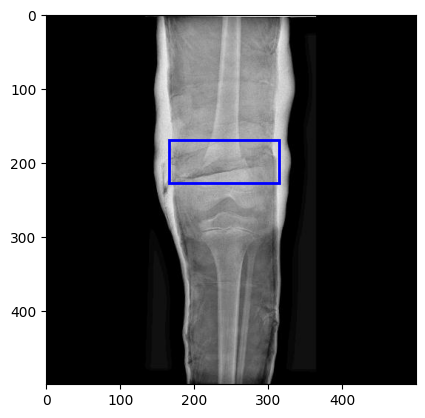

In [34]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
loader = test_loader
model.eval()
all_predictions = []
ground_truths = []

with torch.no_grad():
    for images, targets in loader:
        images = list(image.to(device) for image in images)
        # Perform inference
        outputs = model(images)

        nms_predictions = [apply_nms(pred, 0.1) for pred in outputs]
        predictions = nms_predictions
        for j in range(BATCH_SIZE):

            boxes = predictions[j]['boxes']
            scores = predictions[j]['scores']
            label = targets[j]['boxes']
            img = images[j].to('cpu')
            max_x = img.shape[2]
            max_y = img.shape[1]
            img_t = img.unsqueeze(0)
            all_predictions.append(predictions)
            ground_truths.append(targets)
            # Convert tensor to numpy array
            img_np = img.permute(1, 2, 0).numpy()
            fig, ax = plt.subplots(1)
            ax.imshow(img_np)

            for box, score in zip(boxes, scores):

                    x_min, y_min, x_max, y_max = box.tolist()
                    x_min = x_min * max_x
                    y_min = y_min * max_y
                    x_max = x_max * max_x
                    y_max = y_max * max_y

                    color = (1, 0, 0, score.item())
                    rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=5, edgecolor=color, facecolor='none')

                    ax.add_patch(rect)

            for l in label:

                    x_min, y_min, x_max, y_max = l.tolist()
                    x_min = x_min * max_x
                    y_min = y_min * max_y
                    x_max = x_max * max_x
                    y_max = y_max * max_y

                    rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='b', facecolor='none')
                    ax.add_patch(rect)

            plt.show()
        break
